# INFO 3350/6350

## Lecture 11: Static word embeddings

## Words as vectors

**Big picture: static word embeddings replace each word in our corpus with a vector** (typically of dimensionality between 100 and 1,000) **that captures the range of meanings of that word. We can use these vectors in place of token counts as the input features for any downstream NLP or text analysis task.**

* We've previously represented **documents** as vectors
    * Usually, vectors of word counts
    * Or, with topic models, as vectors of topics
* Limits of words, often discussed
    * In brief: some words are more alike than others, but word counts don't reflect this fact
    * Topic models helped to address this problem
    * Today, a different approach: **word embeddings**
* We might like to have a vector for each **word**, which we could in turn use to build our document vectors
    * This will be an *unsupervised* task. We want to produce vectors that place similar words close together in vector space, but we don't want to use human-labled data to do so. We want instead to observe patterns of use in a large corpus.
* Language models
    * Large neural language models achieve state-of-the-art performance on many NLP tasks
    * These models generally seek to predict a word (or other element of a text sequence) on the basis of the words around it
    * General architecture is:
        * Embedding layer. Counts of words transformed into contextual vectors. Initially, weights are random. In the case of word embeddings, we want to learn the proper weights as our output objective.
        * Intermediate (hidden) layer. Neural layers that can learn non-linear relationships between words and embeddings.
        * Output layer. Optimize an objective function (for example, highest probability of next word, given an input sequence).
    * `word2vec` (2013) showed that we can do without the intermediate layer if we just want to produce word embeddings
        * This simplifies the computation, so we can use *much* more input text
        *  `word2vec` has numerous limitations, however, and is generally considered outdated. We will get to language models very soon, but `word2vec` is still very useful to understand.
* CBOW vs. skip-gram
    * `word2vec` can use two different models: Continuous bag of words (CBOW) and skip-gram
    * CBOW is more "traditional." Objective is to predict a word given the *n* words before and after it.
    * Skip-gram "flips" the prediction task. Try to predict the *n* contextual words, given a seed word.
    * CBOW is faster to train and better captures *syntax* (plurals are closer to other plurals in vector space)
    * Skip-gram is slower to train and better captures *semantic* relationships ('king' moves  closer to 'prince' than to 'kings')
* Training is slow either way, so using pretrained embeddings is standard practice, but ...
    * Embedded relationships and biases of training set
    * Change over time
    * Polysemy remains within the embedding
        * "Class" vector has components of education and of social status, for example
    * Once a model is trained, you cannot add words to its vocabulary (you will encounter OOV words)
    * Word embeddings are "static". What does that mean here?

## Let's *use* some embeddings

We're not going to train them, because that's slow and requires lots of corpus text. In a future lecture, we'll discuss transfer learning. Transfer learning allows us to use a modest amount of new training data to update a larger, pretrained model.

### We need a `spaCy` medium or large model

The small models that we used in the previous lecture do not include vectors. If you haven't already installed the large model (which includes `GloVe` embeddings, an alternative to `word2vec`), run the code below in a terminal to download and install it.

```
python -m spacy download en_core_web_lg
```

In [1]:
# set up spaCy NLP object and load model
import spacy
nlp = spacy.load("en_core_web_lg") # Note '_lg' = large model

### Words in vector space

Take a quick look at some vectors in embedding space. We begin by loading (a sample of) the embedding space, so that we can learn its PCA representation ...

In [2]:
# load embeddings from model, reduce via PCA, plot some example words
import matplotlib.pyplot as plt
import numpy as np
from   sklearn.decomposition import PCA

# sample embedding space
pct_to_sample = 100 # how much of the vector space to sample?
tokens_with_vector = []
for string in nlp.vocab.strings: # not all tokens have vectors; get those that do
    if nlp.vocab[string].has_vector:
        tokens_with_vector.append(string)
tokens_in_sample = np.random.choice(tokens_with_vector, int(len(tokens_with_vector) * pct_to_sample/100), replace=False)

# get embeddings
   # pre-allocate numpy array to hold embeddings
embedding_space = np.zeros((len(tokens_in_sample), nlp.vocab.vectors_length), dtype='f')
for i, token in enumerate(tokens_in_sample):
    embedding_space[i] = nlp.vocab[token].vector

# reduce dimensions for plotting
pca = PCA()
pca.fit(embedding_space)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


... then we get the PCA reductions of a few words to visualize.

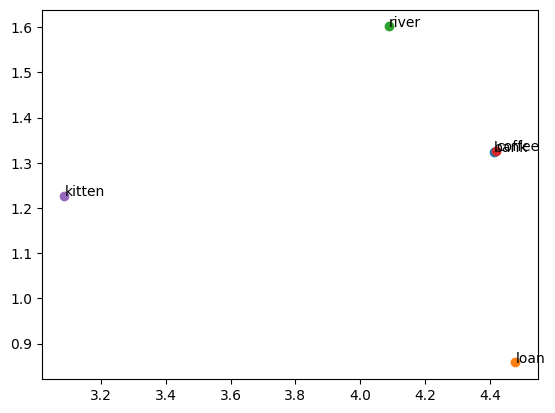

In [4]:
# get vectors for sample words, reduce dimensions, and plot
test_words = ['bank', 'loan', 'river', 'coffee', 'kitten',]

# pre-allocate
test_embeddings = np.zeros((len(test_words), nlp.vocab.vectors_length), dtype='f')

# retrieve embeddings
for i, word in enumerate(test_words):
    test_embeddings[i] = nlp.vocab[word].vector
    
# reduce dimensions in learned space
X = pca.transform(test_embeddings)

# plot
fig, ax = plt.subplots()
for i in range(len(test_words)):
    ax.scatter(X[i,0], X[i,1])
    ax.text(X[i,0], X[i,1], test_words[i])
plt.show()

### Word similarities

In [5]:
# How similar are the words 'king' and 'queen' in Web text?
from sklearn.metrics.pairwise import cosine_similarity

print("king -> queen similarity:", cosine_similarity(
    nlp.vocab['king'].vector.reshape(1,-1), # reshape into a 2d vector with single row
    nlp.vocab['queen'].vector.reshape(1,-1)
).item())

king -> queen similarity: 0.7252610325813293


### Vector math

Now we ask: can we remove some part of a word's meaning, add a different part, and end up closer to a specific endpoint?

Another way to think about this is to imagine the task as an analogy. For example, `man:king :: woman: ___`. Many readers would complete the analogy with `queen`. Let's see if embeddings do something similar ...

In [6]:
# Vector math: king - man + woman -> closer to queen?
king_to_queen_vector = nlp.vocab['king'].vector - nlp.vocab['man'].vector + nlp.vocab['woman'].vector
print("king - man + woman -> queen similarity:", cosine_similarity(
    king_to_queen_vector.reshape(1,-1), 
    nlp.vocab['queen'].vector.reshape(1,-1)
).item())

king - man + woman -> queen similarity: 0.7880843877792358


Notice that we've moved closer to `queen` by subtracting `man` and adding `woman`.

In [7]:
# Try the same with Paris and Berlin
print("Paris -> Berlin:                   ", cosine_similarity(
    nlp.vocab['Paris'].vector.reshape(1,-1), # reshape into a 2d vector with single row
    nlp.vocab['Berlin'].vector.reshape(1,-1)
).item())

paris_to_berlin_vector = nlp.vocab['Paris'].vector - nlp.vocab['France'].vector + nlp.vocab['Germany'].vector
print("Paris - France + Germany -> Berlin:", cosine_similarity(
    paris_to_berlin_vector.reshape(1,-1), 
    nlp.vocab['Berlin'].vector.reshape(1,-1)
).item())

Paris -> Berlin:                    0.5989030599594116
Paris - France + Germany -> Berlin: 0.7547402381896973


So, we can use vectors on these kinds of "analogy" tasks. How could we find the *n* most similar words to a given vector?

### Corpus-wide similarities

In [8]:
# How large is our model?
string_count = 0
vector_count = 0
for string in nlp.vocab.strings:
    string_count+=1
    if nlp.vocab[string].has_vector:
        vector_count+=1
print("Vocab size:", string_count)
print("Has vectors:", vector_count)

Vocab size: 710267
Has vectors: 684752


So, our language model has 514,092 words with embeddings (and about 265,000 more words for which we lack embeddings; we'll ignore those).

Next, we'll create a word-embedding matrix over our vocabulary, so that we can calculate distances between any pair of words. This matrix will have 514,092 rows (one for each word that has an embedding in our model) and 300 columns (the number of dimensions in the embedding representation).

We initialize the output matrix with zeros, since it's much faster to update an existing numpy array than it is to append to it.

Note that there's an easier way to find the most similar vectors to a taget word in spaCy, but we're showing the details for clarity ...

In [9]:
%%time
# Make a word-vector martrix with labels
vector_matrix = np.zeros([vector_count,nlp.vocab.vectors_length]) # Initialize the output matrix
counter = 0
vocab_dict = {} # Dictionary to hold word index positions in the matrix
vocab_list = [] # List to hold words in order
for string in nlp.vocab.strings: # iterate over the strings in our model
    if nlp.vocab[string].has_vector: # only want the ones with embeddings
        vocab_dict[string] = counter # record index position of this word
        vocab_list.append(string) # add to our list of words
        # l2-normalize the vector and update matrix
        vector_matrix[counter] = nlp.vocab[string].vector/nlp.vocab[string].vector_norm
        counter+=1 # increment counter
print("Matrix shape:", vector_matrix.shape)

Matrix shape: (684752, 300)
CPU times: user 7.78 s, sys: 131 ms, total: 7.91 s
Wall time: 7.96 s


You might be tempted to iterate over the rows in the output matrix, calculating the similarity between each one and your target vector. This is slow. Instead, we'll use matrix math.

The **dot product** of two vectors is the sum of their element-wise products. If the vectors are (L2) normalized, their dot product = their cosine similarity. If you take the dot product of a (2D) matrix with a (1D) vector, the result is a (1D) vector representing the dot products of the 1D vector with each of the row vectors in the matrix.

In [10]:
# example dot product
vec1 = [0.5, 0.1]
vec2 = [1.0, 0.1]
result = 0.5*1.0 + 0.1*0.1
print("Result of vec1.vec2:", result)
assert np.dot(vec1, vec2) == result

Result of vec1.vec2: 0.51


In [11]:
# aside: non-normalized vector lengths are proportional to word frequency in the training corpus
np.sqrt(np.sum(nlp.vocab['the'].vector**2))

np.float32(4.70935)

In [12]:
# vector_norm = length
nlp.vocab['the'].vector_norm

np.float32(4.70935)

In [13]:
nlp.vocab["arithmetic"].vector_norm

np.float32(6.893589)

In [14]:
nlp.vocab["dyad"].vector_norm

np.float32(6.464924)

In [15]:
nlp.vocab["an"].vector_norm

np.float32(5.5624833)

In [16]:
# Calculate similarities to 'king' via dot products
similarities = np.dot(vector_matrix, vector_matrix[vocab_dict['king']])
similarities.shape

(684752,)

Note that NumPy dot products are really fast to calculate!

In [17]:
# Get 10 most-similar words to 'king'
# argsort returns lowest to highest, so we get the last 10, then reverse
top_n = np.argsort(similarities)[-10:][::-1] 
for i in top_n:
    print(vocab_list[i], similarities[i])

king 1.0000000265848845
KING 1.0000000265848845
King 1.0000000265848845
KIng 1.0000000265848845
KINGS 0.7876614074511339
Kings 0.7876614074511339
kings 0.7876614074511339
prince 0.7337737081547175
PRINCE 0.7337737081547175
Prince 0.7337737081547175


In [18]:
# Most similar to our king - man + woman vector
# Also, make this prettier and with less repetition

def print_most_similar(matrix, vector, vocab_list, n=20):
    sim = np.dot(matrix, vector/np.linalg.norm(vector))
    sorted_sims = np.argsort(sim)[-n:][::-1] #argsort return lowest to highest, so we get the last n, then reverse
    last_word = ''
    for i in sorted_sims:
        current_word = vocab_list[i].lower()
        if current_word != last_word: # filter out duplicates
            print(f'{current_word:<15}{sim[i]:.4}')
            last_word = current_word
            
print_most_similar(vector_matrix, king_to_queen_vector, vocab_list)

king           0.8024
queen          0.7881
prince         0.6401
kings          0.6209
princess       0.6126
royal          0.5801
throne         0.5787


### Pure spacy

Do the same thing, but entirely within spacy ...

In [19]:
best = nlp.vocab.vectors.most_similar(king_to_queen_vector.reshape(1,-1), n=20)

In [20]:
# Examine the output
best

(array([[13176088972490086564,  5247273317732208552, 11742085837932180620,
          3708855936003160130, 13482751041672084183,  9482215189757771475,
          7669862725032101845,  6861946004817705414,  6166572574100323016,
          4380109347444303261,  6780500829325665625,  8545790742077103879,
         17063575602949770323, 18168826635621557613,  7116441749935341331,
         17366637372717416615, 10491259323710399641, 10685699743126678532,
          2449416162135563425,  4019143091659839274]], dtype=uint64),
 array([[209062, 238387, 190538, 190456, 186245, 212287, 219750, 172634,
         238721, 148824, 232668, 136159, 113390, 183529, 109608, 113454,
         224773,  92853,  76355,  47286]], dtype=int32),
 array([[0.8024, 0.7881, 0.6401, 0.6209, 0.6126, 0.5801, 0.5787, 0.5744,
         0.5634, 0.5521, 0.529 , 0.5254, 0.5151, 0.5052, 0.4976, 0.4868,
         0.4798, 0.4783, 0.4751, 0.4711]], dtype=float32))

Note that the output format of spacy's `most_similar()` function is a tuple that contains three items: an array of word hashes (unique IDs), an array of index positions in the vector matrix, and an array of similarity values.

In [21]:
# Print top matches
hashes, lines, scores = best
last_word = ''
for i in range(len(hashes[0])):
    current_word = nlp.vocab[hashes[0][i].item()].text.lower()
    if current_word != last_word:
        print(f'{current_word:<15}{scores[0][i]:.4}')
        last_word = current_word

king           0.8024
queen          0.7881
prince         0.6401
kings          0.6209
princess       0.6126
royal          0.5801
throne         0.5787
queens         0.5744
monarch        0.5634
kingdom        0.5521
empress        0.529
lady           0.5254
woman          0.5151
princes        0.5052
mother         0.4976
duke           0.4868
emperor        0.4798
reign          0.4783
goddess        0.4751
lord           0.4711


In [22]:
def print_most_similar(word, n=20):
    target_vector = nlp.vocab[word].vector/nlp.vocab[word].vector_norm
    hashes, lines, scores = nlp.vocab.vectors.most_similar(target_vector.reshape(1,-1), n=n)
    last_word = ''
    for i in range(len(hashes[0])):
        current_word = nlp.vocab[hashes[0][i].item()].text.lower()
        if current_word != last_word:
            print(f'{current_word:<15}{scores[0][i]:.4}')
            last_word = current_word

In [23]:
# get most similar vectors to each of a list of target terms
for term in ['economy', 'economic', 'money', 'wealth', 'child', 'housework']:
    print_most_similar(term, n=5)
    print()

economy        1.0
economic       0.834
economies      0.7998
recession      0.7351
downturn       0.696

economic       1.0
economy        0.834
economies      0.7699
crisis         0.7357
financial      0.728

money          1.0
cash           0.8191
dollars        0.7552
pay            0.7542
paying         0.742

wealth         1.0
prosperity     0.7057
riches         0.6847
fortune        0.6369
wealthy        0.623

child          1.0
children       0.8332
parents        0.7356
infant         0.724
kids           0.7076

housework      1.0
chores         0.8052
yardwork       0.6721
chore          0.6643
errands        0.6356



## Document similarities using word embeddings

It's fun to study words, but we mostly care about documents. How can we use word embeddings to perform the kinds of document-similarity tasks that have occupied us so far this semester?

One possible answer is that we might replace each word token with its corresponding embedding, then, for each document, average the embeddings to get a representation of the document. We can then use those document representations (of dimensionality equal to the dimensionality of our embedding vectors) as input to any of the methods we've already discussed.

Here, we use our derived document representations to measure the cosine similarity between different (toy) documents. We do this both with and without removing stopwords, and we compare our measures to those using word counts (rather than embeddings).

In [24]:
# Doc similarities
from sklearn.feature_extraction.text import TfidfVectorizer

# Set up sample sentences
sentences = [
    'The young cat is smaller than the old dog.',
    'The kitten is tinier than the elderly hound.',
    'Not all sentences are about animals, nor about their properties.',
    'It is a truth universally acknowledged ...'
]

# process sentences into spacy nlp objects
docs = []
for sentence in sentences:
    tokens = nlp(sentence)
    docs.append(tokens)
    
def remove_noninformative_tokens(doc):
    '''
    Takes a spacy-processed document.
    Returns a list of spacy token objects without stopwords, punctuation, or embedding-less tokens.
    '''
    culled = [token for token in doc if not (token.is_stop or token.is_punct) and token.has_vector]
    return(culled)

def embedding_similarity(X,Y):
    '''
    Takes two lists of spacy token objects.
    Returns cosine similarity between their embedding representations.
    '''
    mean_vector_X = np.mean([token.vector for token in X], axis=0)
    mean_vector_Y = np.mean([token.vector for token in Y], axis=0)
        # note below reshape 1D -> 2D array. 2D version is 1 row x n columns
    cos_similarity = cosine_similarity(mean_vector_X.reshape(1, -1), mean_vector_Y.reshape(1, -1))
    return(cos_similarity.item()) # use .item() to get single value from array
    
def token_similarity(X,Y):
    '''
    Takes two lists of spacy tokens.
    Returns cosine similarity between their tokens.
    '''
    doc1 = ' '.join([token.text for token in X])
    doc2 = ' '.join([token.text for token in Y])
    vectorizer = TfidfVectorizer(use_idf=False)
    vectors = vectorizer.fit_transform([doc1, doc2])
    return(cosine_similarity(vectors[0], vectors[1]).item())
    
for i, doc in enumerate(docs):
    doc1_nostops = remove_noninformative_tokens(doc)
    for j in range(len(docs)):
        if j>i:
            doc2_nostops = remove_noninformative_tokens(docs[j])
            print(f"Doc {i}: {docs[i]}")
            print(f"Doc {j}: {docs[j]}")
            print(f"   Built-in similarity: {doc.similarity(docs[j]):.3}")
            print(f"   Hand similarity:     {embedding_similarity(doc, docs[j]):.3}")
            print(f"   Embed sim, no stops: {embedding_similarity(doc1_nostops, doc2_nostops):.3}")
            print(f"   Token sim, no stops: {token_similarity(doc1_nostops, doc2_nostops):.3}")
            print()

Doc 0: The young cat is smaller than the old dog.
Doc 1: The kitten is tinier than the elderly hound.
   Built-in similarity: 0.926
   Hand similarity:     0.926
   Embed sim, no stops: 0.735
   Token sim, no stops: 0.0

Doc 0: The young cat is smaller than the old dog.
Doc 2: Not all sentences are about animals, nor about their properties.
   Built-in similarity: 0.789
   Hand similarity:     0.789
   Embed sim, no stops: 0.492
   Token sim, no stops: 0.0

Doc 0: The young cat is smaller than the old dog.
Doc 3: It is a truth universally acknowledged ...
   Built-in similarity: 0.735
   Hand similarity:     0.735
   Embed sim, no stops: 0.312
   Token sim, no stops: 0.0

Doc 1: The kitten is tinier than the elderly hound.
Doc 2: Not all sentences are about animals, nor about their properties.
   Built-in similarity: 0.725
   Hand similarity:     0.725
   Embed sim, no stops: 0.343
   Token sim, no stops: 0.0

Doc 1: The kitten is tinier than the elderly hound.
Doc 3: It is a truth uni